# Desarrollo de distintos modelos con machine para predecir la probabilidad de que un cliente pague un préstamo

## Contexto de negocio:
* El equipo de ciencia de datos ha construido un modelo de regresión simpple para predecir la probabilidad en el incumplimiento de préstamos pero resulta ser que el modelo está funcionando mucho peor en producción que en las pruebas.

## Objetivo del trabajo:
* Construir un modelo de probabilidad que sea lo suficientemente certero para ponerlo en producción

## Fases de trabajo:
1. Exploración de datos para determinar las transformaciones de variables apropiadas.
2. Ajustar algunos modelos simples.
3. Utilizar validación cruzada para seleccionar el mejor modelo simple.
4. Contruir modelos más complejos utilizando validación cruzada.

* Ver como agrego estos o se quitan:
    1. Combinar diversas técnicas de pre-modelación trabajando con clasificación binaria.
    2. Optimizar el modelo usando regresión logística y varias métricas como ROC/AUC.

## Dataset a utilizar:
1. El archivo 'loan_light.csv' contiene los detalles de 5000 préstamos
2. El archivo 'loan_param.xlsx' contiene la descripción de cada covariable

In [47]:
# Importación de libreria
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

### 1. Exploración de los datos

#### 1.1. Creación de los DataFrame

In [48]:
datos = pd.read_csv('datasets/loan_light.csv')
datos = datos.sample(frac=1)           # Desordenar las filas
datos.head()

,annual_inc,application_type,avg_cur_bal,chargeoff_within_12_mths,delinq_2yrs,dti,emp_length,grade,inq_last_12m,installment,...,num_actv_bc_tl,pub_rec_bankruptcies,home_ownership,term,mort_acc,num_tl_90g_dpd_24m,purpose,year,loan_default,job
209,37809.0,Individual,3715.0,0.0,0.0,27.71,9,B,1.0,131.89,...,2.0,0.0,RENT,36,0.0,0.0,debt_consolidation,2017,0,assistant
2700,31000.0,Individual,3432.0,0.0,0.0,10.88,1,B,1.0,99.74,...,1.0,0.0,OWN,36,0.0,0.0,major_purchase,2016,0,coordinator
2335,65000.0,Individual,8612.0,0.0,0.0,20.35,10,F,0.0,962.32,...,6.0,0.0,MORTGAGE,60,1.0,0.0,debt_consolidation,2016,1,other
228,175000.0,Individual,13978.0,0.0,0.0,9.24,1,C,6.0,679.58,...,1.0,0.0,OWN,36,0.0,0.0,house,2018,0,executive
3929,70000.0,Individual,5913.0,0.0,0.0,20.81,5,B,4.0,782.90,...,2.0,1.0,MORTGAGE,36,2.0,0.0,debt_consolidation,2016,0,tech


In [49]:
datos.keys()

Index(['annual_inc', 'application_type', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_2yrs', 'dti', 'emp_length', 'grade',
       'inq_last_12m', 'installment', 'loan_amnt', 'num_actv_bc_tl',
       'pub_rec_bankruptcies', 'home_ownership', 'term', 'mort_acc',
       'num_tl_90g_dpd_24m', 'purpose', 'year', 'loan_default', 'job'],
      dtype='object')

In [50]:
df_descripcion = pd.read_excel('datasets/loan_param.xlsx').dropna()
df_descripcion.head()

,BrowseNotesFile,Description
0,loanAmnt,The listed amount of the loan applied for by t...
1,annualInc,The self-reported annual income provided by th...
2,application_type,Indicates whether the loan is an individual ap...
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months


In [51]:
df_descripcion.style.set_properties(subset=['Description'], **{'width': '1000px'})

,BrowseNotesFile,Description
0,loanAmnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,annualInc,The self-reported annual income provided by the borrower during registration.
2,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
3,avg_cur_bal,Average current balance of all accounts
4,chargeoff_within_12_mths,Number of charge-offs within 12 months
5,delinq2Yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
6,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,grade,LC assigned loan grade
9,homeOwnership,"The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER."


#### 1.2. Visualización con diagrama de barras para mostrar los préstamos pagos y los impagos

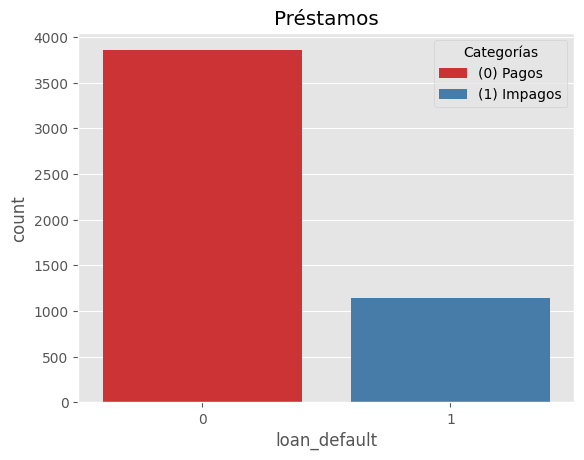

In [52]:
# Creación de paleta de colores
paleta = sns.color_palette("Set1")

# Creación del gráfico
sns.countplot(x='loan_default', data=datos, palette=paleta)
plt.title('Préstamos')

# Creación de leyenda
plt.legend(labels=['(0) Pagos', '(1) Impagos'], loc='upper right', title='Categorías')

plt.show()

#### 1.3. Visualización de un histograma con los ingresos anuales

Text(0.5, 0, 'Ingreso anual')

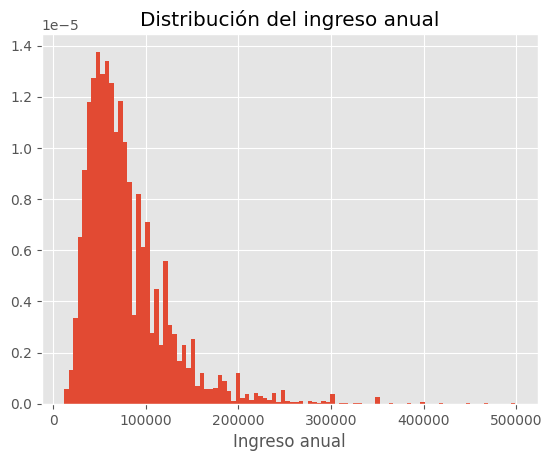

In [53]:
datos.annual_inc.hist(bins=100, density=True)
plt.title('Distribución del ingreso anual')
plt.xlabel('Ingreso anual')

Como los datos están sesgados, se resuelve hacer una transformación logarítmica

Text(0.5, 0, 'ingreso anual')

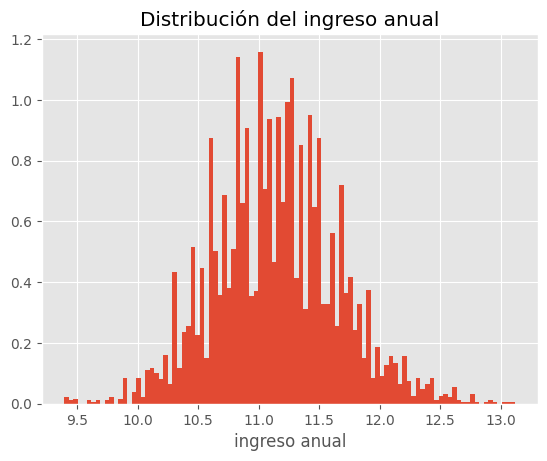

In [54]:
np.log(datos.annual_inc).hist(bins=100, density=True)
plt.title('Distribución del ingreso anual')
plt.xlabel('ingreso anual')

#### 1.4. Observaciones

1.4.1. ¿Es la distribución del ingreso anual diferente entre los aplicantes que no pagaron y los que sí pagaron?

Text(0.5, 1.0, 'Salario anual -- Estatus del préstamo')

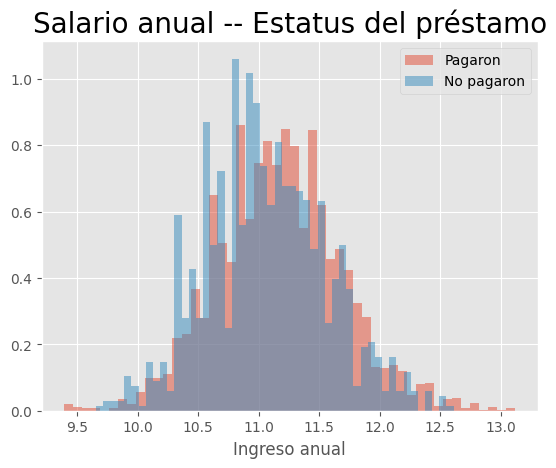

In [55]:
np.log(datos['annual_inc'][datos.loan_default == 0]).hist(bins=50, density=True, alpha=0.5, label='Pagaron')
np.log(datos['annual_inc'][datos.loan_default == 1]).hist(bins=50, density=True, alpha=0.5, label='No pagaron')

plt.xlabel('Ingreso anual')
plt.legend()
plt.title('Salario anual -- Estatus del préstamo', fontsize=20)

1.4.2. Se puede observar que, si bien, arriba de 11.0 se empieza a notar que el ingreso ayuda a incrementar las posibilidades de que paguen el préstamo, no existe una diferencia significativa

#### 1.5. Asociación entre el ingreso anual y las cuotas mensuales

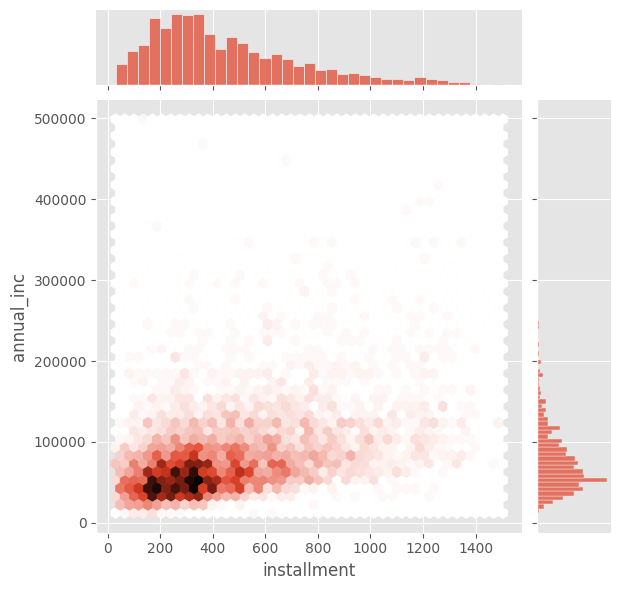

In [56]:
sns.jointplot(x='installment', y='annual_inc', data=datos, kind='hex')

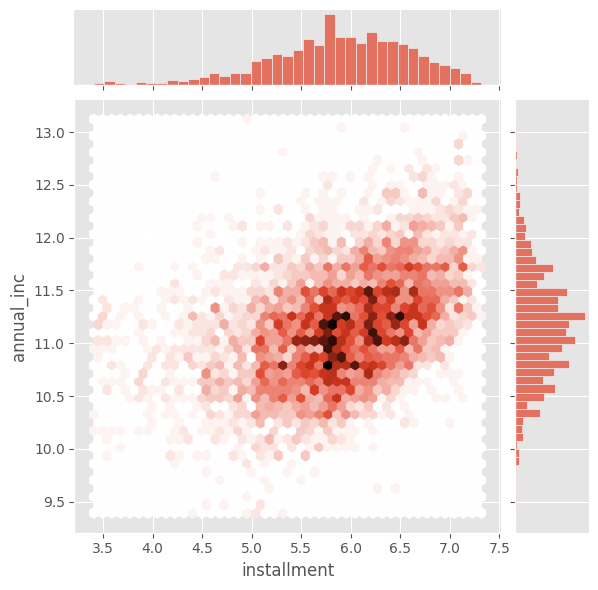

In [57]:
# Debido a que están sesgados, se usará la función logarítmica

sns.jointplot(x=np.log(datos['installment']), y=np.log(datos['annual_inc']), kind='hex')
plt.show()

#### 1.4. Observaciones
* Existe una relación lineal entre los logaritmos de los ingresos anuales y las cuotas mensuales. Esto quiere decir que a medida que aumentan los ingresos anuales, tambien aumenta el monto que aceptan de sus cuotas mensuales.